# **Actor Critic**

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

print("所有库导入成功！")

所有库导入成功！


In [2]:
# Actor 网络 - 策略网络
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.fc3(x), dim=-1)
        return action_probs

print("Actor网络定义完成！")

Actor网络定义完成！


In [3]:
# Critic 网络 - 价值网络
class Critic(nn.Module):
    def __init__(self, state_size, hidden_size=128):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

print("Critic网络定义完成！")

Critic网络定义完成！


In [ ]:
# Actor-Critic 智能体
class ActorCritic:
    def __init__(self, state_size, action_size, lr_actor=0.001, lr_critic=0.001, gamma=0.99):
        self.gamma = gamma
        
        # 创建Actor和Critic网络
        self.actor = Actor(state_size, action_size)
        self.critic = Critic(state_size)
        
        # 优化器
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        
    def get_action(self, state):
        """根据当前状态选择动作"""
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs = self.actor(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob
    
    def update(self, state, action, reward, next_state, done, log_prob):  # (state, action) -> next_state
        """更新Actor和Critic网络"""
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        reward = torch.FloatTensor([reward])
        
        # 计算TD误差 (Critic的目标)
        current_value = self.critic(state)
        next_value    = self.critic(next_state)
        
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma * next_value  # TD Error 核心
            
        td_error = td_target - current_value
        
        # 更新Critic网络 (最小化价值函数误差)
        critic_loss = td_error.pow(2)
        self.critic_optimizer.zero_grad()
        critic_loss.backward(retain_graph=True)
        self.critic_optimizer.step()
        
        # 更新Actor网络 (策略梯度)
        actor_loss = -log_prob * td_error.detach()  # detach是为了不更新critic
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

print("ActorCritic智能体定义完成！")

ActorCritic智能体定义完成！


In [ ]:
# 训练函数
def train_actor_critic(episodes=1000):
    # 创建环境
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]  # 4 (位置、速度、角度、角速度)
    action_size = env.action_space.n  # 2 (左、右)
    
    # 创建智能体
    agent = ActorCritic(state_size, action_size)
    
    # 记录奖励
    scores = deque(maxlen=100)
    episode_scores = []
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):  # 新版gym返回(state, info)
            state = state[0]
            
        total_reward = 0
        
        while True:
            # 选择动作
            action, log_prob = agent.get_action(state)
            
            # 执行动作
            next_state, reward, terminated, truncated, _ = env.step(action)   # (state, action) -> next_state
            done = terminated or truncated
            
            # 更新智能体
            agent.update(state, action, reward, next_state, done, log_prob)
            
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        scores.append(total_reward)
        episode_scores.append(total_reward)
        
        # 每100个episode打印一次结果
        if episode % 100 == 0:
            avg_score = np.mean(scores)
            print(f"Episode {episode}, Average Score: {avg_score:.2f}")
    
    env.close()
    return episode_scores, agent

print("训练函数定义完成！")

训练函数定义完成！


In [6]:
# 开始训练
print("开始训练Actor-Critic智能体...")
scores, trained_agent = train_actor_critic(episodes=500)
print("训练完成！")

开始训练Actor-Critic智能体...
Episode 0, Average Score: 10.00
Episode 100, Average Score: 48.70
Episode 200, Average Score: 76.76
Episode 300, Average Score: 163.16
Episode 400, Average Score: 168.60
训练完成！


/tmp/ipykernel_148636/980038046.py:24: UserWarning: Glyph 22870 (\N{CJK UNIFIED IDEOGRAPH-5956}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_148636/980038046.py:24: UserWarning: Glyph 21169 (\N{CJK UNIFIED IDEOGRAPH-52B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_148636/980038046.py:24: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_148636/980038046.py:24: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_148636/980038046.py:24: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_148636/980038046.py:24: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_148636/980038046.py:24: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAP

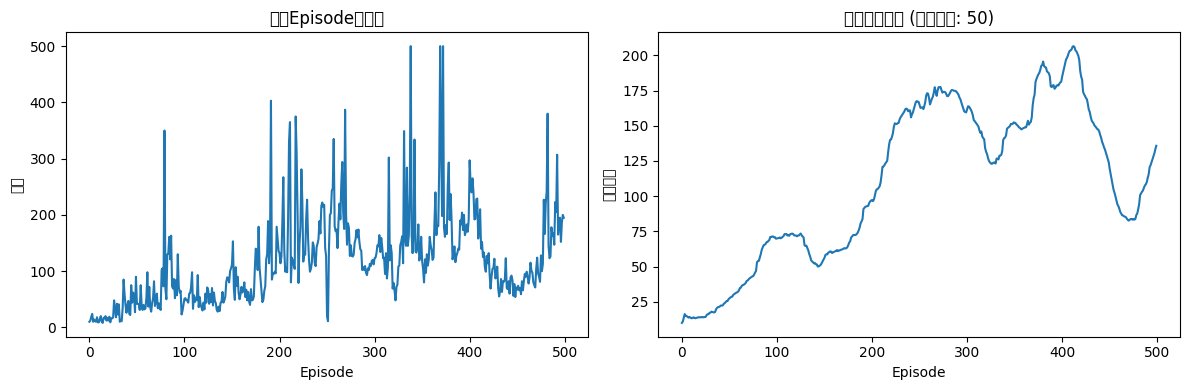

最后100个episode的平均奖励: 129.91


In [7]:
# 绘制训练结果
plt.figure(figsize=(12, 4))

# 绘制每个episode的奖励
plt.subplot(1, 2, 1)
plt.plot(scores)
plt.title('每个Episode的奖励')
plt.xlabel('Episode')
plt.ylabel('奖励')

# 绘制移动平均奖励
plt.subplot(1, 2, 2)
window_size = 50
moving_avg = []
for i in range(len(scores)):
    start_idx = max(0, i - window_size + 1)
    moving_avg.append(np.mean(scores[start_idx:i+1]))

plt.plot(moving_avg)
plt.title(f'移动平均奖励 (窗口大小: {window_size})')
plt.xlabel('Episode')
plt.ylabel('平均奖励')

plt.tight_layout()
plt.show()

print(f"最后100个episode的平均奖励: {np.mean(scores[-100:]):.2f}")

In [8]:
# 测试训练好的智能体
def test_agent(agent, num_episodes=5):
    env = gym.make('CartPole-v1')
    test_scores = []
    
    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
            
        total_reward = 0
        step_count = 0
        
        while True:
            # 使用训练好的智能体选择动作
            action, _ = agent.get_action(state)
            
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
                
            state = next_state
            total_reward += reward
            step_count += 1
            
            if done:
                break
        
        test_scores.append(total_reward)
        print(f"测试Episode {episode + 1}: 奖励 = {total_reward}, 步数 = {step_count}")
    
    env.close()
    print(f"\n测试结果 - 平均奖励: {np.mean(test_scores):.2f}")
    return test_scores

# 测试智能体
test_scores = test_agent(trained_agent)

测试Episode 1: 奖励 = 202.0, 步数 = 202
测试Episode 2: 奖励 = 223.0, 步数 = 223
测试Episode 3: 奖励 = 218.0, 步数 = 218
测试Episode 4: 奖励 = 213.0, 步数 = 213
测试Episode 5: 奖励 = 238.0, 步数 = 238

测试结果 - 平均奖励: 218.80


# **Actor-Critic 算法解释**

## 核心概念

**Actor-Critic** 是一种结合了价值函数方法和策略梯度方法的强化学习算法：

### 1. **Actor (策略网络)**
- 负责学习策略，即在给定状态下选择什么动作
- 输出动作的概率分布
- 使用策略梯度进行更新

### 2. **Critic (价值网络)** 
- 负责评估状态的价值
- 输出状态价值函数 V(s)
- 用来计算TD误差，指导Actor的学习

## 算法流程

1. **状态输入**: 将环境状态输入Actor和Critic网络
2. **动作选择**: Actor根据策略选择动作
3. **环境交互**: 执行动作，获得奖励和下一状态
4. **TD误差计算**: Critic计算时序差分误差
5. **网络更新**: 
   - Critic: 最小化价值函数预测误差
   - Actor: 使用TD误差作为优势函数更新策略

## 优势
- **低方差**: Critic提供baseline，减少策略梯度的方差
- **在线学习**: 可以实时学习，不需要完整的episode
- **稳定性**: 比纯策略梯度方法更稳定

In [9]:
# 📚 简化版Actor-Critic (更容易理解)
import torch
import torch.nn as nn
import gymnasium as gym
import numpy as np

class SimpleActorCritic:
    def __init__(self, state_dim, action_dim):
        # 简单的线性网络
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=0.001)
    
    def get_action(self, state):
        """选择动作"""
        probs = self.actor(torch.FloatTensor(state))
        action = torch.multinomial(probs, 1).item()
        return action, torch.log(probs[action])
    
    def update(self, state, reward, next_state, action_log_prob, done):
        """核心更新逻辑"""
        # 1. 计算TD误差
        current_value = self.critic(torch.FloatTensor(state))
        next_value = self.critic(torch.FloatTensor(next_state)) if not done else 0
        td_target = reward + 0.99 * next_value
        td_error = td_target - current_value
        
        # 2. 更新Critic (价值网络)
        critic_loss = td_error.pow(2)
        self.critic_optimizer.zero_grad()
        critic_loss.backward(retain_graph=True)
        self.critic_optimizer.step()
        
        # 3. 更新Actor (策略网络)
        actor_loss = -action_log_prob * td_error.detach()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

print("简化版Actor-Critic定义完成！这个版本更容易理解算法的核心思想。")

简化版Actor-Critic定义完成！这个版本更容易理解算法的核心思想。
